In [1]:
import torch
import torch.nn as nn
import torchvision as tv
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as Func


In [2]:
logostxt=open("C:\\Users\\kryzh\\Desktop\\datasets\\carBrandLogos\\archive\\Car_Brand_Logos\\spisok.txt")
logos_list=logostxt.read().split("\n")
#logos_list=['Burger King','KFC','McDonalds','Other','Starbucks','Subway']
logos_list.sort()
CountOfClasses=len(logos_list)
print(CountOfClasses)
logos_list

8


['hyundai',
 'lexus',
 'mazda',
 'mercedes',
 'opel',
 'skoda',
 'toyota',
 'volkswagen']

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device is',device)

device is cuda


In [4]:
path = 'C:\\Users\\kryzh\\Desktop\\datasets\\carBrandLogos\\archive\\Car_Brand_Logos\\Train'

In [5]:
transforms=tv.transforms.Compose([
    tv.transforms.Resize((80,80)),
    tv.transforms.ToTensor()
    
])

In [6]:
from matplotlib.transforms import Transform
dataset=tv.datasets.ImageFolder(root=path,transform=transforms)

In [7]:
dataloader=torch.utils.data.DataLoader(dataset,batch_size=2,shuffle=True,)

(tensor([[[0.7961, 0.7961, 0.7961,  ..., 0.7725, 0.7765, 0.7725],
         [0.7961, 0.7961, 0.7961,  ..., 0.7765, 0.7725, 0.7686],
         [0.7961, 0.7961, 0.7961,  ..., 0.7804, 0.7725, 0.7647],
         ...,
         [0.9843, 0.7608, 0.6549,  ..., 0.8941, 0.9176, 0.9882],
         [0.9961, 0.9333, 0.7882,  ..., 0.9529, 0.9686, 0.9882],
         [0.9961, 0.9804, 0.9725,  ..., 0.9922, 0.9922, 0.9961]],

        [[0.8549, 0.8549, 0.8549,  ..., 0.8353, 0.8353, 0.8314],
         [0.8549, 0.8549, 0.8549,  ..., 0.8392, 0.8314, 0.8275],
         [0.8549, 0.8549, 0.8549,  ..., 0.8431, 0.8314, 0.8235],
         ...,
         [0.9843, 0.8353, 0.7804,  ..., 0.8941, 0.9176, 0.9882],
         [0.9961, 0.9569, 0.8667,  ..., 0.9529, 0.9686, 0.9882],
         [0.9882, 0.9804, 0.9922,  ..., 0.9922, 0.9922, 0.9961]],

        [[0.9451, 0.9451, 0.9451,  ..., 0.8980, 0.9176, 0.9216],
         [0.9451, 0.9451, 0.9451,  ..., 0.9020, 0.9176, 0.9176],
         [0.9451, 0.9451, 0.9451,  ..., 0.9059, 0.9137, 0

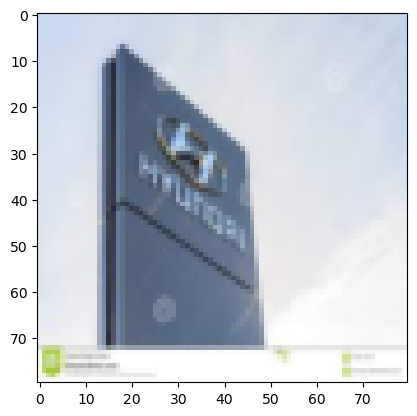

In [8]:
plt.imshow(dataset[118][0].numpy().transpose((1,2,0)))
print(dataset[118])
#print(dataset[50][0].numpy().transpose((1,2,0)).shape)
#print(dataset[50][0].shape)
#m=nn.Conv2d(3,32,kernel_size=3,padding=0)
#m=nn.AdaptiveAvgPool2d((1,1))
#print(m(dataset[50][0]).shape) 
#plt.imshow(m(dataset[50][0]).numpy().transpose((1,2,0)))
#print(dataset[50])

In [9]:
class CNA(nn.Module):
  def __init__(self,in_ch=32,out_ch=32):
    super().__init__()
    self.conv=nn.Conv2d(in_ch,out_ch,kernel_size=3,padding=1)
    self.norm=nn.BatchNorm2d(out_ch)
    self.act=nn.ReLU()

  def forward(self,x):
    out=self.conv(x)
    out=self.norm(out)
    out=self.act(out)
    return out
net=CNA()
net=net.to(device)

In [10]:
class MyConvModel(nn.Module):
  def __init__(self, base_ch=64):
    super().__init__()
    cna1_1=CNA(3,base_ch) 
    cna1_2=CNA(base_ch,base_ch) 
    
    cna2_1=CNA(base_ch,2*base_ch)
    cna2_2=CNA(2*base_ch,2*base_ch)

    cna3_1=CNA(2*base_ch,4*base_ch)
    cna3_2=CNA(4*base_ch,4*base_ch)
    
    cna4_1=CNA(4*base_ch,8*base_ch)
    cna4_2=CNA(8*base_ch,8*base_ch)
    #cna4_3=CNA(8*base_ch,8*base_ch)

    cna5_1=CNA(8*base_ch,8*base_ch)
    cna5_2=CNA(8*base_ch,8*base_ch)
    cna5_3=CNA(8*base_ch,8*base_ch)
    
    act=nn.ReLU()

    Linear_1=nn.Linear(8*base_ch,16*base_ch)
    Linear_2=nn.Linear(16*base_ch,4*base_ch)
    #Linear_3=nn.Linear(16*base_ch,8*base_ch)
    Linear_4=nn.Linear(4*base_ch,CountOfClasses)

    maxpool=nn.MaxPool2d((2,2),stride=2)
    avgpool=nn.AdaptiveAvgPool2d((1,1))
    flatten=nn.Flatten()
    
    self.model = nn.Sequential(
          cna1_1,cna1_2,maxpool,# (16,3,60,60)-> (16,32,30,30)
          cna2_1,cna2_2,maxpool,#(16,32,30,30)->(16,64,15,15)
          cna3_1,cna3_2,maxpool,
          cna4_1,cna4_2,maxpool,
          #cna5_1,cna5_2,cna5_3,avgpool,
          cna5_1,cna5_2,avgpool,
          flatten,
          Linear_1,act,
          Linear_2,act,
          #Linear_3,act,
          Linear_4
          
    )
  def forward(self,x):
    return self.model(x)
net=MyConvModel()
net=net.to(device)

In [11]:
# vggNet=tv.models.vgg.vgg19(weights=tv.models.VGG19_Weights)
# classifier=nn.Sequential(
#     nn.Linear(25088,600),
#     nn.ReLU(),
#     nn.Linear(600,600),
#     nn.ReLU(),
#     nn.Linear(600,CountOfClasses)
# )
# vggNet.classifier=classifier
# for param in vggNet.features.parameters():
#     param.requires_grad=False
# #net = SimpleConvNet()
# net=vggNet
# net = net.to(device)

In [12]:
loss_fn = nn.CrossEntropyLoss()
#loss_fn=nn.MSELoss()
optimizer=torch.optim.Adam(net.parameters(),lr=1e-4, betas=(0.9, 0.999))
#optimizer=torch.optim.Adam(net.classifier.parameters(),lr=1e-4, betas=(0.9, 0.999))
def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)
print(count_parameters(net))

10200648


In [13]:
def get_accuracy(pred, label):
    answer =(pred.argmax(1)==label.argmax(1)).type(torch.float).sum().item()

    #answer = pred.detach().numpy().argmax(1) == label.numpy().argmax(1) 
    return answer

In [14]:
#net = torch.load('C:\\Users\\kryzh\\weightsOfLogoClassifierbatch1')

In [15]:
def realCheck():

    path="C:\\Users\\kryzh\\Desktop\\datasets\\carBrandLogos\\archive\\Car_Brand_Logos\\mytest\\2.jpg"
    img=Image.open(path)
    tensorImg=transforms(img)
    batchImg=torch.unsqueeze(tensorImg,0)
    batchImg=batchImg.to(device)
    out=net(batchImg)
    #print(out)
    test=out
    out=out.squeeze()
    out=out.tolist()
    #print(out)
    #print(max(out))
    #print(out.index(max(out)))
    print(logos_list[out.index(max(out))])
    #print(sum(out))
    y_pos = np.arange(len(logos_list))
    plt.bar(y_pos, out, align='center', alpha=0.5)
    plt.xticks(y_pos, logos_list)
    plt.ylabel('Value')
    plt.title('Bar title')

    plt.show()

In [16]:
epochs=40
for epoch in range(epochs):
    loss_val=0
    acc_val=0

    for sample in dataloader:
        img,label = sample

        label = label.to(device)
        label = Func.one_hot(label, num_classes=CountOfClasses).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
        img = img.to(device)
        
        optimizer.zero_grad()
       
        
        pred = net (img)
        
        loss = loss_fn(pred, label)
        loss.backward()

        optimizer.step()
        
        loss_val+=loss.item()
        acc_val += get_accuracy(pred.cpu(), label.cpu())
    

    loss_val /= len(dataloader)
    acc_val /= len(dataloader)*2
    print("epoch=",epoch,"loss=",loss_val ,"accruracy=",acc_val)

epoch= 0 loss= 2.0820588282203523 accruracy= 0.13444709626093873
epoch= 1 loss= 2.078721481556919 accruracy= 0.13404932378679396
epoch= 2 loss= 2.0707325310392237 accruracy= 0.15234685759745425
epoch= 3 loss= 2.0660494097472184 accruracy= 0.14956245027844073
epoch= 4 loss= 2.035331433219576 accruracy= 0.17541766109785203
epoch= 5 loss= 2.0028403664545684 accruracy= 0.18973747016706444
epoch= 6 loss= 1.9616524385097203 accruracy= 0.2096260938743039
epoch= 7 loss= 1.9261784809585971 accruracy= 0.22275258552108193
epoch= 8 loss= 1.922709227272131 accruracy= 0.24781225139220367
epoch= 9 loss= 1.8979243652253466 accruracy= 0.2557677008750994
epoch= 10 loss= 1.8751533888310028 accruracy= 0.27724741447891804
epoch= 11 loss= 1.8456841961391026 accruracy= 0.28758949880668255
epoch= 12 loss= 1.8141607723733026 accruracy= 0.3038981702466189
epoch= 13 loss= 1.7834043474356713 accruracy= 0.3198090692124105
epoch= 14 loss= 1.750669118043631 accruracy= 0.324582338902148
epoch= 15 loss= 1.684360738372

mercedes


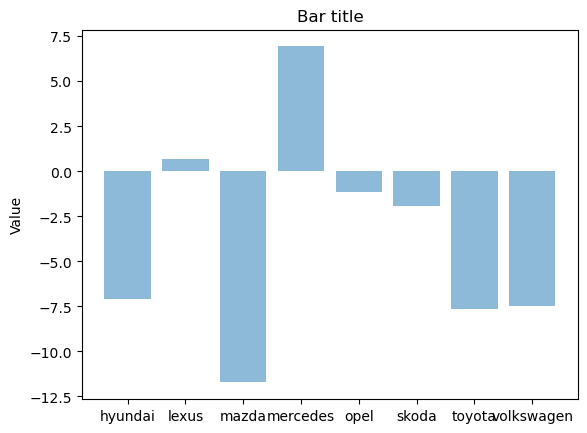

In [17]:

realCheck()

In [18]:
torch.save(net, 'C:\\Users\\kryzh\\weightsOfLogoClassifierbatch1')

In [19]:
#net = MyConvModel()
#net = torch.load('D:\\myprogect\\pytorch\\weightsOfLogoClassifierbatch1')
#net.eval()

Test for one image

test for test dataset dataset img =1460

In [20]:
a=np.zeros(CountOfClasses)
path = 'C:\\Users\\kryzh\\Desktop\\datasets\\carBrandLogos\\archive\\Car_Brand_Logos\\Test'
dataset=tv.datasets.ImageFolder(root=path,transform=transforms)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True,num_workers=4)
loss_val=0
acc_val=0
for sample in dataloader:
    img,label = sample

    label = label.to(device)
    label = Func.one_hot(label, num_classes=CountOfClasses).float()
        # label=Func.one_hot(label,num_classes=10)
        #label = label.float()
        #label = label.unsqueeze(1)
    img = img.to(device) 
    pred = net (img)
    out=pred.squeeze()
    out=out.tolist()
    a[out.index(max(out))]+=1
    loss = loss_fn(pred, label)
         
    loss_val+=loss.item()
    acc_val += get_accuracy(pred.cpu(), label.cpu())
    
loss_val /= len(dataloader)
acc_val /= len(dataloader)
print("loss=",loss_val ,"accruracy=",acc_val)
print(a)
print(sum(a))

loss= 1.8238101941726745 accruracy= 0.7
[43. 70. 43. 51. 44. 44. 60. 45.]
400.0


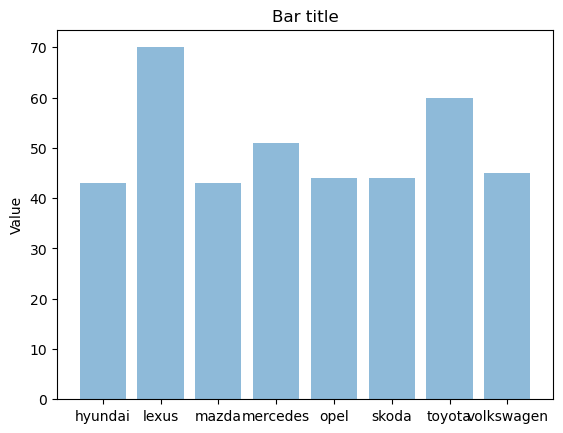

In [21]:
y_pos = np.arange(len(logos_list))
plt.bar(y_pos, a, align='center', alpha=0.5)
plt.xticks(y_pos, logos_list)
plt.ylabel('Value')
plt.title('Bar title')

plt.show()

эта хуйня не работает